# Navigation

---

In this notebook we explore the Unity ML-Agents environment, Navigation for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). We solve the environment using deep Q learning, applying a few different extensions of the algorithm to implement double DQL, priority queues and  N step learning.

## 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment! You will see a new window opening which displays the current view of the environment. As the agent interacts with the environment you will be able to see the activity of the agent. The notebook has been developed on Linux (Ubuntu 18.04) but this should work on Mac and Windows too.

In [2]:
import platform

environment_files = {"Linux":"./Banana_Linux/Banana.x86_64", "Darwin":"./Banana_Mac/Banana.app", "Windows":"./Banana_Windows_x86_64/Banana.exe"}
env = UnityEnvironment(file_name=environment_files[platform.system()])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## 3. Train the agents

The cells below setup the code for training an agent to solve the environment. Following this we train a number of different agents. For each agent we save the weights into a pth file with the corresponding name (e.g. weights for the baseline agent save to `baseline.pth`).

In [5]:
# Imports and setup plotting
import importlib
import collections
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Agent code
import agent

%matplotlib notebook

In [6]:
# The main training loop 
def train(env, agent, brain_name, weights_file, n_episodes=1000, max_t=1000, num_steps=1, gamma=0.99):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = collections.deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        score = agent.learn_episode(env, brain_name, max_t)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), weights_file)
            break
    return scores

In [7]:
# Construct and train an agent
def train_agent(experiment_name, use_double_dqn, use_priority_queue, hyperparams, results):
    
    print('\nRunning training for experiment ' + experiment_name)

    # Refresh the agent code (in case it has been updated)
    importlib.reload(agent)

    # Create the agent
    agent_train = agent.Agent(state_size=37, action_size=4, seed=0, \
                              use_double_dqn=use_double_dqn, use_priority_queue=use_priority_queue, hyperparams=hyperparams)

    # Run the training and plot the scores
    scores = train(env, agent_train, brain_name, experiment_name + ".pth")
    
    experiment = [experiment_name] * len(scores)
    episode = list(range(len(scores)))
    
    new_df = pd.DataFrame(list(zip(experiment, episode, scores)), 
               columns =['experiment', 'episode', 'score'])
    
    return results.append(new_df) 

In [8]:
results = pd.DataFrame(columns =['experiment', 'episode', 'score']) 

### Baseline DQN

For this agent we use a basic DQN implementation. The underlying network is a fully connected network with three layers the first two with 64 units and the last with 4 units corresponding to the number of actions. A buffer is kept of the last 10,000 experiences and every 4th new experience a batch of 64 is selected randomly from the buffer to be learnt from. The algorithm applies epsilon greedy strategy with an epsilon schedule which exponentially decays from 1.0 to 0.01 using a multiplier of 0.995 per episode.

In [9]:
hyperparams = {}
hyperparams["fc1_units"]  = 64
hyperparams["fc2_units"]  = 64
hyperparams["buffer_size"]  = 10000
hyperparams["batch_size"]  = 64
hyperparams["gamma"]  = 0.99
hyperparams["tau"]  = 0.001
hyperparams["learning_rate"]  = 0.0005
hyperparams["update_every"]  = 4
hyperparams["eps_start"]  = 1.0
hyperparams["eps_end"]  = 0.01
hyperparams["eps_decay"]  = 0.995
hyperparams["num_steps"]  = 1

results = train_agent("baseline", False, False, hyperparams, results)


Running training for experiment baseline
Episode 100	Average Score: 1.01
Episode 200	Average Score: 4.24
Episode 300	Average Score: 7.54
Episode 400	Average Score: 10.53
Episode 500	Average Score: 11.54
Episode 600	Average Score: 12.69
Episode 610	Average Score: 13.00
Environment solved in 510 episodes!	Average Score: 13.00


### Priority Queue

For this agent we use a basic DQN implementation extended with a priority queue. In this case rather than sampling the experiences in the batch uniformly they are sampled in proportion to the priority which is calculated as

$$p_t = (\lvert \delta_t \rvert + \epsilon) ^ \alpha $$

where $\delta_t$ is the TD loss for experience at step t. Initially when a new experience is added to the buffer it is given the maximum priority to in order to ensure it is learnt from soon. Priorities are updated after each batch evaluation.

Note that due to the changes in sampling we also need to adjust the loss function to compensate for the bias we are introducing otherwise. The parameter which controls this is `beta` which we put on a linear schedule as determined by the `priority_beta_start`, `priority_beta_end` and `priority_beta_schedule_experiences` hyperparameters. When `beta` is 1 we are fully adjusted for bias, smaller values reduce the correction at the start of training in order to speed convergence. If we have $N$ experiences with probabilities $P_t$ then the weights used in loss calculation will be

$$w_t = (N P_t) ^{-\beta}$$

In [10]:
hyperparams = {}
hyperparams["priority_epsilon"] = 0.0001
hyperparams["priority_alpha"]  =  0.6
hyperparams["priority_beta_start"]  = 0.4
hyperparams["priority_beta_end"]  = 1.0
hyperparams["priority_beta_schedule_experiences"] = 300000
hyperparams["fc1_units"]  = 64
hyperparams["fc2_units"]  = 64
hyperparams["buffer_size"]  = 10000
hyperparams["batch_size"]  = 64
hyperparams["gamma"]  = 0.99
hyperparams["tau"]  = 0.001
hyperparams["learning_rate"]  = 0.0005
hyperparams["update_every"]  = 4
hyperparams["eps_start"]  = 1.0
hyperparams["eps_end"]  = 0.01
hyperparams["eps_decay"]  = 0.995
hyperparams["num_steps"]  = 1

results = train_agent("priority_queue", False, True,  hyperparams, results)


Running training for experiment priority_queue
Episode 100	Average Score: 0.85
Episode 200	Average Score: 3.55
Episode 300	Average Score: 4.90
Episode 400	Average Score: 7.71
Episode 500	Average Score: 7.66
Episode 600	Average Score: 7.75
Episode 700	Average Score: 9.17
Episode 800	Average Score: 11.21
Episode 900	Average Score: 12.31
Episode 947	Average Score: 13.01
Environment solved in 847 episodes!	Average Score: 13.01


### Double DQN

In this variant we use the local network to select the action with highest value (from the ending state of the experience) and use the target network to evaluate the value of the state / action pair rather than using the target network for both purposes. This is to avoid overestimation of the value function. 

In [11]:
hyperparams = {}
hyperparams["fc1_units"]  = 64
hyperparams["fc2_units"]  = 64
hyperparams["buffer_size"]  = 10000
hyperparams["batch_size"]  = 64
hyperparams["gamma"]  = 0.99
hyperparams["tau"]  = 0.001
hyperparams["learning_rate"]  = 0.0005
hyperparams["update_every"]  = 4
hyperparams["eps_start"]  = 1.0
hyperparams["eps_end"]  = 0.01
hyperparams["eps_decay"]  = 0.995
hyperparams["num_steps"]  = 1

results = train_agent("double_dqn", use_double_dqn=True, use_priority_queue=False, \
                      hyperparams=hyperparams, results=results)


Running training for experiment double_dqn
Episode 100	Average Score: 0.91
Episode 200	Average Score: 3.69
Episode 300	Average Score: 8.60
Episode 400	Average Score: 10.18
Episode 500	Average Score: 11.86
Episode 547	Average Score: 13.01
Environment solved in 447 episodes!	Average Score: 13.01


### 2 Step DQN

This variant applies updates which use the next N=2 steps of the agent to form an experience. This is loosely justified as an iterative application of the Bellman equation but noting that the we are assuming the actual selected actions on each step are optimal when in fact they may have been selected randomly (due to epsilon value). The equation for the 2 step version below can be written as

$$Q(s_t , a_t) = r_t + \gamma r_{t+1} + \gamma^2 \max_a Q(s_{t+2}, a)$$

In [12]:
hyperparams = {}
hyperparams["fc1_units"]  = 64
hyperparams["fc2_units"]  = 64
hyperparams["buffer_size"]  = 10000
hyperparams["batch_size"]  = 64
hyperparams["gamma"]  = 0.99
hyperparams["tau"]  = 0.001
hyperparams["learning_rate"]  = 0.0005
hyperparams["update_every"]  = 4
hyperparams["eps_start"]  = 1.0
hyperparams["eps_end"]  = 0.01
hyperparams["eps_decay"]  = 0.995
hyperparams["num_steps"]  = 2

results = train_agent("2-step", use_double_dqn=False, use_priority_queue=False, \
                      hyperparams=hyperparams, results=results)


Running training for experiment 2-step
Episode 100	Average Score: 0.43
Episode 200	Average Score: 4.04
Episode 300	Average Score: 7.17
Episode 400	Average Score: 10.11
Episode 500	Average Score: 12.71
Episode 522	Average Score: 13.04
Environment solved in 422 episodes!	Average Score: 13.04


### 3 Step DQN

As above except that 3 steps are used.

$$Q(s_t , a_t) = r_t + \gamma r_{t+1} +  \gamma^2 r_{t+2} + \gamma^3 \max_a Q(s_{t+3}, a)$$

In [13]:
hyperparams = {}
hyperparams["fc1_units"]  = 64
hyperparams["fc2_units"]  = 64
hyperparams["buffer_size"]  = 10000
hyperparams["batch_size"]  = 64
hyperparams["gamma"]  = 0.99
hyperparams["tau"]  = 0.001
hyperparams["learning_rate"]  = 0.0005
hyperparams["update_every"]  = 4
hyperparams["eps_start"]  = 1.0
hyperparams["eps_end"]  = 0.01
hyperparams["eps_decay"]  = 0.995
hyperparams["num_steps"]  = 3

results = train_agent("3-step", use_double_dqn=False, use_priority_queue=False, \
                      hyperparams=hyperparams, results=results)


Running training for experiment 3-step
Episode 100	Average Score: 0.57
Episode 200	Average Score: 3.89
Episode 300	Average Score: 6.37
Episode 400	Average Score: 9.03
Episode 500	Average Score: 9.52
Episode 600	Average Score: 11.07
Episode 700	Average Score: 12.03
Episode 745	Average Score: 13.01
Environment solved in 645 episodes!	Average Score: 13.01


### 10 Step DQN

As above except that 10 steps are used.

In [14]:
hyperparams = {}
hyperparams["fc1_units"]  = 64
hyperparams["fc2_units"]  = 64
hyperparams["buffer_size"]  = 10000
hyperparams["batch_size"]  = 64
hyperparams["gamma"]  = 0.99
hyperparams["tau"]  = 0.001
hyperparams["learning_rate"]  = 0.0005
hyperparams["update_every"]  = 4
hyperparams["eps_start"]  = 1.0
hyperparams["eps_end"]  = 0.01
hyperparams["eps_decay"]  = 0.995
hyperparams["num_steps"]  = 10

results = train_agent("10-step", use_double_dqn=False, use_priority_queue=False, \
                      hyperparams=hyperparams, results=results)


Running training for experiment 10-step
Episode 100	Average Score: 0.73
Episode 200	Average Score: 2.30
Episode 300	Average Score: 3.59
Episode 400	Average Score: 5.17
Episode 500	Average Score: 6.61
Episode 600	Average Score: 6.78
Episode 700	Average Score: 6.78
Episode 800	Average Score: 6.53
Episode 900	Average Score: 5.71
Episode 1000	Average Score: 5.60


### 2 Step Prioritized Double DQN

This version combines all the enhancements to DQN at the same time.

In [15]:
hyperparams = {}
hyperparams["priority_epsilon"] = 0.0001
hyperparams["priority_alpha"]  =  0.6
hyperparams["priority_beta_start"]  = 0.4
hyperparams["priority_beta_end"]  = 1.0
hyperparams["priority_beta_schedule_experiences"] = 300000
hyperparams["fc1_units"]  = 64
hyperparams["fc2_units"]  = 64
hyperparams["buffer_size"]  = 10000
hyperparams["batch_size"]  = 64
hyperparams["gamma"]  = 0.99
hyperparams["tau"]  = 0.001
hyperparams["learning_rate"]  = 0.0005
hyperparams["update_every"]  = 4
hyperparams["eps_start"]  = 1.0
hyperparams["eps_end"]  = 0.01
hyperparams["eps_decay"]  = 0.995
hyperparams["num_steps"]  = 2

results = train_agent("double-priority-2-step", use_double_dqn=True, use_priority_queue=True, \
                      hyperparams=hyperparams, results=results)


Running training for experiment double-priority-2-step
Episode 100	Average Score: 0.59
Episode 200	Average Score: 2.01
Episode 300	Average Score: 3.56
Episode 400	Average Score: 6.56
Episode 500	Average Score: 8.61
Episode 600	Average Score: 9.88
Episode 700	Average Score: 9.731
Episode 800	Average Score: 11.19
Episode 900	Average Score: 12.33
Episode 1000	Average Score: 12.07


In [16]:
results.to_csv("results.csv")

## 5 Code

We break down the code into a number of different modules. The hyperparameters associated with each module are noted below.

### agent.py

This is the implementation of the agent. It has separate parameters to use Double DQN or Priority Queue extensions and is otherwise calibrated via the hyperparams dictionary. Its main method for training is the `learn_episode (self, env, brain_name, max_t)` method which instructs the agent to run a single episode and learn from it returning the episode score.

| Parameter | Value | Description |
|-----------|-------|-------------|
| gamma | 0.99 | The reward discount |
| tau | 0.001 | A parameter used when updating the target network from the local network which controls the interpolation between the models |
| learning_rate | 0.0005 | The learning rate |
| update_every | 4 | One batch is processed every 4 episodes |
| eps_start | 1.0 | Starting value of epsilon (probability of randomized action) |
| eps_end | 0.01 | Ending value of epsilon (probability of randomized action) |
| eps_decay | 0.995 | Decay factor for epsilon (probability of randomized action) for each episode |

### buffer.py

This contains the replay buffer code. The buffer can can either provide for random samples (via the `SimpleBuffer` class) or prioritized samples (via the `PriorityBuffer` class).  The basic parameter are


| Parameter | Value | Description |
|-----------|-------|-------------|
| buffer_size | 10000 | The size of the buffer |
| batch_size | 64 | The number of experiences processed in each batch |

If using priorities then we also specify the following hyperparameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| priority_epsilon | 0.0001 | A small offset to the TD loss to ensure some minimum priority for each episode |
| priority_alpha | 0.6 | The power to which the TD loss is raised to get priority |
| priority_beta_start | 0.4 | The starting value of the beta parameter |
| priority_beta_end | 1.0 | The ending value of the beta parameter |
| priority_beta_schedule_experiences | 300000 | The number of experiences over which the beta changes from start to end value (linear schedule) |


### model.py

This contains the neural network used to run a function approximation for the state / action value function. The network uses three fully connected layers. The sizes of the layers are

| Parameter | Value | Description |
|-----------|-------|-------------|
| fc1_units | 64 | The number of units in the first layer |
| fc2_units | 64 | The number of units in the second layer |

The third layer has 4 units corresponding to the number of possible actions.

### experience.py
 
This contains the experience generator which can generate Experience named tuples used by the agent to learn. The FirstAndLastExperienceSource class is capable of generating N step Experiences where the next_state in the Experience corresponds to the state N steps after the starting state and the reward includes all rewards earned in those N steps (discounted by gamma).

| Parameter | Value | Description |
|-----------|-------|-------------|
| num_steps | 1 or 2 or 3 or 10 | The number of steps in each experience |



## 6 Comparing Training

As can be seen from the plots below the baseline DQN solves in around 500 episodes while 2-step and double DQN both converge slightly faster. The 3 step is slightly slower and the 10 step never converges. It seems for this problem the priority queue also makes convergence much slower possibly because the hyperparameters are not well tuned. The slower convergence we bring in for the priority queue also impacts the combined agent which (narrowly) fails to converge in the first 1000 episodes.

<IPython.core.display.Javascript object>


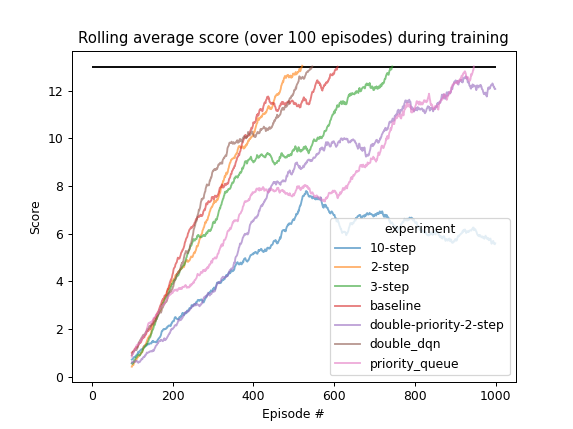

In [17]:
res_pivot = results.pivot_table(index='episode', columns='experiment', values='score', dropna = False)
res_pivot.rolling(100).mean().plot(alpha=0.6)
plt.hlines(13, 0, 1000)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Rolling average score (over 100 episodes) during training');

<IPython.core.display.Javascript object>


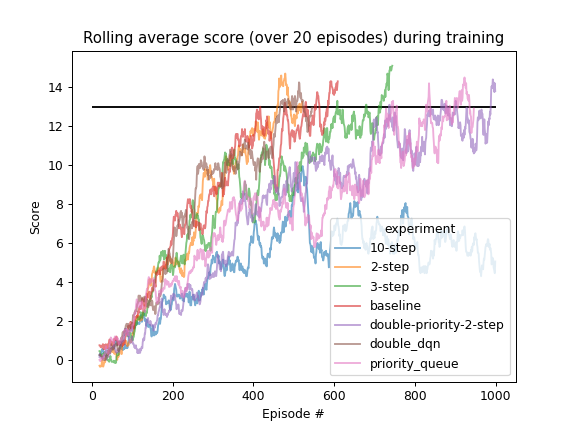

In [18]:
res_pivot = results.pivot_table(index='episode', columns='experiment', values='score', dropna = False)
res_pivot.rolling(20).mean().plot(alpha=0.6)
plt.hlines(13, 0, 1000)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Rolling average score (over 20 episodes) during training');

## 7 Future Work

The project could be further extended to consider more DQN enhancements (the remaining improvements in the Rainbow algorithm for example). It would also be interesting to examine how to train the agent to get the maximum possible score on the problem rather than focusing on the speed of beating an average score of 13. Another possible direction would be to consider automated hyperparameter tuning via the Hyperopt package or similar this would be particularly relevant for the priority queue example as the performance of this seems much worse than expected.